# 0 - TODO
- regularization sur nos données (selection des tournois qui ont un impact sur le temps joué)
- dédoubler les lignes directement depuis le dataframe player / opponent
- % win player vs % win opponent
- continuer à faire des variables dynamiques
- variables dynamiques ne prennent pas en compte le résultat du match considéré
- arbres de décision (random forest etc...)
- dictionnaire des colonnes
- Prédire les matches qui durent plus de 3h
- !!!!! __Séparer bo3 et bo5__

https://github.com/JeffSackmann/tennis_atp/issues/86  
these column names all pertain to the winning player ( prefix 'w_').  

winner_ht ... height (metres)  
w_svpt ... number of own serve points contested  
w_1stIn ... number of own first serves in  
w_1stWon ... number of own first serve points won  
w_2ndWon ... number of own second serve points won  
w_SvGms ... number of own service games played  
w_bpSaved ... number of break points against own serve saved  
w_bpFaced ... number of break points against own serve faced  

https://github.com/JeffSackmann/tennis_atp/issues/112  
R = Right hand  
L = Left hand  
U = Unknown hand  

https://github.com/JeffSackmann/tennis_atp/issues/49  
'G', 'M', 'A', 'D':  
G - Grand Slam  
M – Masters  
A – ATP (500 & 250)  
D – Davis Cup  
O – Olympics  

In [58]:
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [60]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

In [83]:
def perc_print(a, b):
    return round((a-b)/a*100)

# I - Importation et nettoyage des données

In [62]:
PATH = '/home/cesar/Desktop/data/'

In [63]:
data = pd.read_csv(PATH+'atp_matches_2010.csv')
for annee in range(2000, 2020):
    data = pd.concat([data, pd.read_csv(PATH+'atp_matches_'+str(annee)+'.csv')], axis=0, sort=False)

print('La base contient {} observations et {} attributs.'.format(data.shape[0], data.shape[1]))

La base contient 64694 observations et 49 attributs.


Les index sont mis à jour.

In [64]:
data.reset_index(inplace=True, drop=True)

Aperçu de la base de donnée.

In [65]:
data.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1,NaN,Andy Roddick,R,188.0,USA,27.348392,103429,NaN,NaN,Peter Luczak,R,183.0,AUS,30.346338,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,Carsten Ball,L,198.0,AUS,22.543463,104999,NaN,NaN,Mischa Zverev,L,190.0,GER,22.370979,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,Richard Gasquet,R,185.0,FRA,23.548255,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,28.451745,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0


Les modifications suivantes sont apportées :
- Transformation des dates au format `datetime`
- Création de la variable `year`
- Suppression des match de la Davis Cup
- Suppression des lignes ne contenant pas de durée du match _'minutes'_
- Suppression des doublons

In [66]:
nb_obs = data.shape[0]
data['tourney_date'] = pd.to_datetime(data['tourney_date'], yearfirst=True, format='%Y%m%d')
data['year'] = data['tourney_date'].apply(lambda x: x.year)
data = data[~data['tourney_name'].str.startswith('Davis Cup')].copy()
data.dropna(subset=['minutes'], inplace=True)
data.drop_duplicates(inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data.shape[0], perc_print(nb_obs, data.shape[0])))

11093 observations supprimées (17.1%).


Suppession des observations dont le score contient des caractères ASCII

In [67]:
def contains_ascii_letter(txt):
    gate = False
    for i in range(len(txt)):
        if txt[i] in string.ascii_letters:
            gate = True
            break
    return gate

In [68]:
nb_obs = data.shape[0]
get_ascii_letter = np.zeros(data.shape[0], dtype=bool)
get_ascii_letter = data['score'].apply(contains_ascii_letter)
data = data[~get_ascii_letter].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data.shape[0], perc_print(nb_obs, data.shape[0])))

1678 observations supprimées (3.1%).


Correction de certaines valeurs aberrantes (suite à des vérifications effectuées en lignes)

In [69]:
data.loc[data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)].index[0], 'minutes'] = 98
data.loc[data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)].index[0], 'minutes'] = 90

__COMMENTAIRE__

In [70]:
data_winner = data.copy()
data_loser = data.copy()
data_winner.rename({'winner_name':'player_name'}, inplace=True)
data_loser.rename({'loser_name':'player_name'}, inplace=True)
data_winner['win_lose'] = ['w' for i in range(len(data_winner))]
data_loser['win_lose'] = ['l' for i in range(len(data_loser))]
data_winner = data_winner.rename(columns=lambda x: re.sub('winner','player',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^w_','player_',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('loser','opponent',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^l_','opponent_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('loser','player',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^l_','player_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('winner','opponent',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^w_','opponent_',x))
data = pd.concat([data_winner, data_loser], axis=0, sort=False)
data.reset_index(inplace=True, drop=True)

# II - Un premier modèle de base

Nous commençons par construire un modèle qui nous servira de baseline pour juger de la qualité des modèles qui le suivront. La mesure de qualité du modèle choisi sera la Mean Squared Error (MSE).  
  
La plupart de nos variables sont des statitstiques concernant directement le match et ne sont donc pas utilisable lors d'une prédiction. Ces variables demanderont d'être aggrégés par la suite afin d'être utilisable pour caractériser un joueur.  
  
Ce modèle de base s'appuiera sur une régression linéaire, ce qui demande au préalable de transformer les variables catégorielles en dummies.

### 2.1 Mise en forme des données

In [72]:
X = data[['tourney_name', 'surface', 'tourney_level', 'player_hand', 'player_age', 'player_rank',
          'opponent_hand', 'opponent_age', 'opponent_rank', 'best_of', 'round', 'year']].copy()
y = data['minutes']

X.shape, y.shape

((103846, 12), (103846,))

On commence par retirer les lignes contenant des valeurs manquantes (non prises en charge par les algorithmes de régressions linéaires)

In [73]:
for col in X.columns:
    print(col, X[col].isna().sum())

tourney_name 0
surface 0
tourney_level 0
player_hand 0
player_age 0
player_rank 150
opponent_hand 0
opponent_age 0
opponent_rank 150
best_of 0
round 0
year 0


In [74]:
X.dropna(axis=0, how='any', inplace=True)
y = y[X.index]

X.shape, y.shape

((103546, 12), (103546,))

### One Hot Encoding des variables catégorielles

Nous observons le nombre de modalitées prises par les variables catégorielles traités

In [75]:
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'player_hand', 'opponent_hand']

In [46]:
for variable in X_qual:
    print(variable, ':', pd.get_dummies(X[variable]).shape[1])

tourney_name : 126
surface : 4
tourney_level : 4
round : 10
player_hand : 3
opponent_hand : 3


La variable `tourney_name` prend 133 modalités. La matrice étant trop sparse nous l'ignorons pour le moment.  
Les autres variables qualitatives seront retraitées de manière à ce que chaque modalité soit encodée par une dummy, en prenant garde au problème de multicolinéarité en utilisant l'option `drop_first=True` de la fonction `get_dummies`.

In [47]:
X_qual.remove('tourney_name')
X.drop(columns='tourney_name', inplace=True)

In [48]:
for variable in X_qual:
    var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
    X.drop(variable, axis=1, inplace=True)
    for col_enc in var_enc.columns:
        X[col_enc] = var_enc[col_enc]

### 2.2 Régression linéaire de `sklearn`

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Nous utilisons finalement la fonction `LinearRegression` en notant que l'intercept est mise par défaut par la fonction (et la gestion de la multicolinéarité est égaelement gérée par défaut par la fonction) 

In [83]:
reg = LinearRegression().fit(X.values, y.values)

y_pred = reg.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', reg.score(X.values, y.values))

MSE : 1103.0369376440242 
Rsquared : 0.28124886302008856


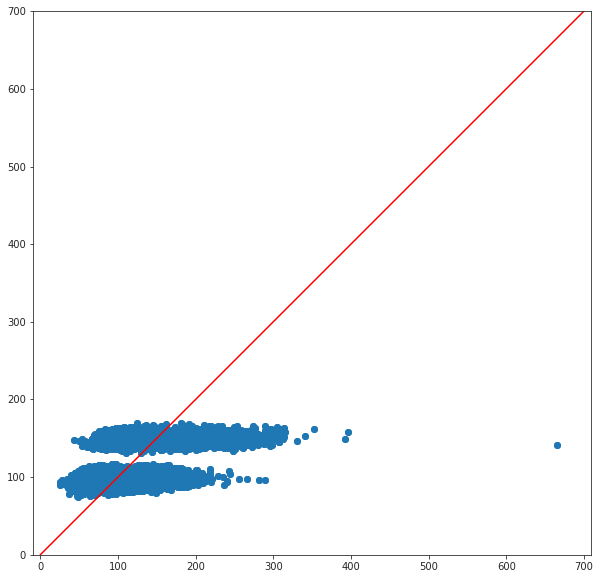

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()

### 2.3 Régression linéaire de `statsmodels`

A l'aide de `statsmodels` qui nous donne le Adj. R-squared qui nous sera utile suite à l'ajout de la variable `tourney_name`. Il faut cependant cette fois-ci introduire une constante dans notre modèle avec la fonction `add_constant` car la fonction `ols` n'en utilise pas par défaut.

In [51]:
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
modele = ols('minutes ~ const + C(tourney_name) + C(surface) + C(tourney_level) + C(player_hand)+ player_age + player_rank\
          + C(opponent_hand) + opponent_age + opponent_rank + best_of + C(round) + year', data=add_constant(data))
resultat = modele.fit()

In [52]:
print('MSE :', resultat.mse_resid,
      '\nRsquared :', resultat.rsquared,
      '\nAdjusted Rsquared :', resultat.rsquared_adj)

MSE : 1099.4010939969057 
Rsquared : 0.2846419557216756 
Adjusted Rsquared : 0.283624937669983


In [59]:
data.groupby('best_of')['minutes'].mean()

best_of
3     96.590159
5    148.603344
Name: minutes, dtype: float64

# III - Création de variables relatives à la rencontre

Les attributs présents dans notre base sont les suivantes.

In [71]:
print('Features de base :')
print(data.columns.values)

Features de base :
['tourney_id' 'tourney_name' 'surface' 'draw_size' 'tourney_level'
 'tourney_date' 'match_num' 'player_id' 'player_seed' 'player_entry'
 'player_name' 'player_hand' 'player_ht' 'player_ioc' 'player_age'
 'opponent_id' 'opponent_seed' 'opponent_entry' 'opponent_name'
 'opponent_hand' 'opponent_ht' 'opponent_ioc' 'opponent_age' 'score'
 'best_of' 'round' 'minutes' 'player_ace' 'player_df' 'player_svpt'
 'player_1stIn' 'player_1stWon' 'player_2ndWon' 'player_SvGms'
 'player_bpSaved' 'player_bpFaced' 'opponent_ace' 'opponent_df'
 'opponent_svpt' 'opponent_1stIn' 'opponent_1stWon' 'opponent_2ndWon'
 'opponent_SvGms' 'opponent_bpSaved' 'opponent_bpFaced' 'player_rank'
 'player_rank_points' 'opponent_rank' 'opponent_rank_points' 'year'
 'win_lose']


A partir de ces données initiales, nous allons créer de nouvelles features dans le but de maximiser le signal inclu dans nos attributs. 

### 3.1 Ecart de classement entre les deux joueurs

In [72]:
data['diff_ranking'] = data.apply(lambda x: abs(x.player_rank - x.opponent_rank), axis=1)
data['diff_ranking'].head(3)

0    70.0
1    56.0
2    36.0
Name: diff_ranking, dtype: float64

### 3.2 Classement moyen des deux joueurs du match

In [73]:
data['avg_ranking'] = data.apply(lambda x: (x.player_rank + x.opponent_rank)/2, axis=1)
data['avg_ranking'].head(3)

0     42.0
1    106.0
2     70.0
Name: avg_ranking, dtype: float64

### 3.3 Les joueurs jouent de la même main

In [74]:
data['same_hand'] = data.apply(lambda x: 1 if x['player_hand']!=x['opponent_hand'] else 0, axis=1)
data['same_hand'].head(3)

0    0
1    0
2    1
Name: same_hand, dtype: int64

# IV - Création de variables caractéristiques du joueur 

Dans cette partie nous devons isoler les matchs joués par chacun des joueurs présents dans notre base pour créer des features différentes en fonction du joueur

In [75]:
nb_joueur = data['player_name'].unique().shape[0]
print('Nombre de joueur différents dans notre base :', nb_joueur)

Nombre de joueur différents dans notre base : 1355


### 4.1 Temps de match moyen d'un joueur

In [76]:
mean_time = data.groupby(['player_name'])['minutes'].mean()
data['player_mean_time'] = np.zeros(data.shape[0])
data['player_mean_time'] = data.apply(lambda x: mean_time[x['player_name']], axis=1)
data[['player_name', 'player_mean_time']].head(3)

,player_name,player_mean_time
0,Andy Roddick,99.921333
1,Carsten Ball,111.421053
2,Richard Gasquet,104.326425


### 4.2 Temps moyen des 10 derniers matchs d'un joueur

__!! A MODIFIER !!__

Nous calculons la moyenne mobile des temps de matchs sur les 10 derniers matchs joué par un joueur à l'aide de la fonction `rolling` de `pandas`.

In [89]:
data['player_mean_10time'] = np.zeros(data.shape[0])
data = data.sort_values(['player_name', 'tourney_date', 'match_num']).copy()
data['player_mean_10time'] = data.sort_values(['player_name',
                                               'tourney_date',
                                               'match_num']
                                             ).groupby('player_name')['minutes'].rolling(window=5,min_periods=1).mean().values

In [90]:
data[data['player_name']=='Roger Federer'][['player_name', 'minutes', 'player_mean_10time']].head(5)

,player_name,minutes,player_mean_10time
3154,Roger Federer,45.0,45.000000
55092,Roger Federer,84.0,64.500000
54518,Roger Federer,68.0,65.666667
5121,Roger Federer,125.0,80.500000
5157,Roger Federer,106.0,85.600000


### 4.3 Nombre de sets moyen joué par un joueur

Nous commencons par extraire le nombre de set joué dans chaque match

In [80]:
data['nb_games'] = data.apply(lambda x: x['score'].split(' '), axis=1)
data['nb_games'] = data.apply(lambda x: [string.split('-') for string in x['nb_games']], axis=1)
data['nb_games'] = data.apply(lambda x: [[int(elt[0]) for elt in liste if len(elt)>0] for liste in x['nb_games']], axis=1)
data['nb_games'] = data.apply(lambda x: [sum(liste) for liste in x['nb_games']], axis=1)
data['nb_games'] = data.apply(lambda x: sum(x['nb_games']), axis=1)

In [81]:
data['nb_games'].unique()

array([14, 15, 13, 28, 19, 21, 24, 17, 41, 18, 34, 37, 16, 27, 36, 23, 32,
       22, 20, 25, 26, 30, 31, 49, 35, 29, 33, 53, 50, 47, 46, 40, 38, 39,
       52, 43, 48, 55, 51, 45, 42, 44, 56, 59, 12, 54, 60, 57, 66, 61, 58,
       64, 10, 65, 62, 63, 11])

Un match de tennis fait au minimum 12 jeux, l'analyse du nombre de set joué dans nos donnée nous indique que certaines rencontrent finissent après 10 et 11 jeux. Nous supprimons ces matchs car ils ne respectent pas ce seuil (l'abandon n'est pas notifié dans la base).

In [82]:
nb_obs = data.shape[0]
data = data[data['nb_games']>=12].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data.shape[0], perc_print(nb_obs, data.shape[0])))

6 observations supprimées (0.0%).


Une fois le nombre de jeux d'une rencontre disponible dans notre base, nous déterminons le nombre de sets joué en moyenne pour chaque joueur.

In [85]:
data['player_mean_games'] = np.zeros(data.shape[0])
for player in data['player_name'].unique():
    player_mean_games = data[data['player_name']==player]['nb_games'].mean()
    data['player_mean_games'].loc[data[data['player_name']==player].index] = player_mean_games.copy()

In [86]:
data['player_mean_games'].describe()

count    103840.000000
mean         25.407261
std           1.354051
min          12.000000
25%          24.783002
50%          25.444251
75%          25.977811
max          53.000000
Name: player_mean_games, dtype: float64

### 4.4 Nombre de sets moyen d'un joueur sur ses 10 derniers matchs

In [91]:
data['player_mean_10games'] = np.zeros(data.shape[0])
data = data.sort_values(['player_name', 'tourney_date', 'match_num']).copy()
data['player_mean_10games'] = data.sort_values(['player_name',
                                                'tourney_date',
                                                'match_num']).groupby('player_name')['nb_games'].rolling(window=5, min_periods=1).mean().values

In [92]:
data[data['player_name']=='Roger Federer'][['player_name', 'nb_games', 'player_mean_10games']].head(5)

,player_name,nb_games,player_mean_10games
3154,Roger Federer,17,17.00
55092,Roger Federer,23,20.00
54518,Roger Federer,20,20.00
5121,Roger Federer,33,23.25
5157,Roger Federer,30,24.60


# BROUILLON

In [ ]:
data['shifted_time'] = data.sort_values(['player_name',
                                               'tourney_date',
                                               'match_num']
                                             ).groupby('player_name')['minutes'].shift(1).values

In [69]:
modele = ols('minutes ~ const + C(tourney_name) + C(surface) + C(tourney_level) +  player_age \
          + opponent_age + best_of + C(round) + year+  diff_ranking + avg_ranking + mean_time' , data=add_constant(data))
resultat = modele.fit()

In [70]:
print('MSE :', resultat.mse_resid,
      '\nRsquared :', resultat.rsquared,
      '\nAdjusted Rsquared :', resultat.rsquared_adj)

MSE : 1068.1618880951862 
Rsquared : 0.3049485091334083 
Adjusted Rsquared : 0.30398055510313027


In [82]:
y_pred = resultat.fittedvalues

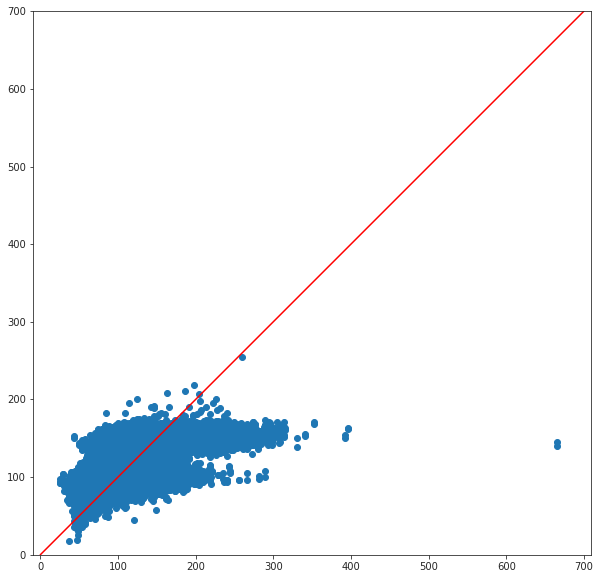

In [80]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()